# Electricity Monthly Demand Forecast
# Prophet Try 1

## Packages

In [1]:
# psycopg2: python package to deal with a postgres database
# pip install psycopg2
import psycopg2
from psycopg2.extras import execute_values

In [2]:
import numpy as np
import pandas as pd
import warnings

import os

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Librería para obtener el usuario que está ejecutando el script
import getpass

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore", category=Warning)
# Seteos de Pandas para ver mejor la info. https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
# In max_columns and max_rows ‘None’ value means unlimited.
pd.set_option('display.max_rows', 100)
# Conviene setear min_rows también porque cuando se superan las max_rows, sólo muestra la cantidad indicada en min_rows.
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.1f}'.format

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [4]:
path_data = r'C:\Users\Usuario\OneDrive\0-Data Science\data_science\energy_demand\data'

## Support Functions

In [5]:
def build_postgres_cnxn(database, host, user, password, port=5432, string_connection=None, verbose=True):
    error_txt = ''
    process_ok = True
    cnxn = None
    cursor = None
    if (not host or not user or not password) and not string_connection:
        process_ok = False
        error_txt = 'ERROR build_postgres_cnxn: Error trying to Build DB connexion: you missed to send host, user or password, or string connection. ' +\
                    ' host: ' + (host if host else 'Missed. ') +\
                    ' user: ' + (user if user else 'Missed.') +\
                    ' password: ' + (password if password else 'Missed.') +\
                    ' String Connection: ' + (string_connection if string_connection else 'Missed.')
        if verbose:
            print(error_txt)
    else:
        if not database:
            if verbose:
                print('WARNING build_postgres_cnxn: no database name provided.')
        try:
            if not string_connection:
                cnxn = psycopg2.connect(database=database, host=host, user=user, password=password, port=port)
            else:
                cnxn = psycopg2.connect(string_connection)
            cursor = cnxn.cursor()
            if verbose:
                print('INFO Module build_postgres_cnxn: DB Connection to host', host, 'Ok')
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            if not string_connection:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database host: ' + host + ' user ' +\
                      user + ' port: ' + str(port) +'\n' + txt)
            else:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database string_connection: ' + string_connection +'\n' + txt)
    return process_ok, error_txt, cnxn, cursor


In [6]:
def pg_select_to_pandas(cursor, sql_query, verbose=True):
    error_txt = ''
    process_ok = True
    df = pd.DataFrame()
    if (not cursor or not sql_query):
        process_ok = False
        error_txt = 'ERROR pg_select_to_pandas: No cursor or Query sent as parameter. ' +\
              ' cursor: ' + (' received.' if cursor else ' missed,') +\
              ' query: ' + (sql_query if sql_query else ' missed.')
        if verbose:
            print(error_txt)
    else:
        try:
            cursor.execute(sql_query)
            data = cursor.fetchall()
            colnames = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(data=data, columns=colnames)
            if verbose:
                print('INFO pg_select_to_pandas: query executed Ok. Number of records returned: ' + str(df.shape[0]))
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            error_txt = 'ERROR pg_select_to_pandas: Error executing query on host: ' + cursor.connection.info.host + ' database ' +\
                  cursor.connection.info.dbname + ' query: ' + sql_query +'\n' + txt
            if verbose:
                print(error_txt)
    return process_ok, error_txt, df

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
#plot_event(df_hist, element, '2021-09-01', '2022-08-30', ['press_suc', 'press_1', 'press_2'], [], title=element
#    , xposition=[], yposition=[33.9, 89, 90], fig_size=[15, 5], return_df=False)

def plot_df(df_, time_since, time_until, time_col, left_feat_lst, right_feat_lst, title="", xposition=[], yposition=[]
    , fig_size=[10, 3], return_df=True, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None):
    """Plot a spot in a timeline
        PARAMS:
        df_: dataframe source of data (must have fields "ts")
        ts *: timestamp column in df_
        time_since *: ts start of period to plot
        time_until *: ts end of period to plot
        left_feat_lst *: list of dataframe features to plot using left axis
        right_feat_lst *: list of dataframe features to plot using right axis
        xposition: list of vertical lines to draw
        texts: list of [x, y, string] for function plt.text()
    """
    colors_lst=['deepskyblue', 'skyblue', 'steelblue', 'dodgerblue', 'indianred', 'firebrick', 'lightsalmon', 'darkorange', 'orange']
    if not right_feat_markers and right_feat_lst:
        right_feat_markers = ['--' for feat in right_feat_lst]
    if not left_feat_markers and left_feat_lst:
        left_feat_markers = ['--' for feat in left_feat_lst]
    fig, ax = plt.subplots()
    df_plot = df_[(df_[time_col].between(time_since, time_until))]
    for idx, feat in enumerate(left_feat_lst):
        df_plot.plot(x=time_col, y=feat, ax=ax, style='-', color=colors_lst[idx], figsize=(fig_size[0], fig_size[1]))
    i=idx+1
    for idx, feat in enumerate(right_feat_lst):
        df_plot.plot(x=time_col, y=feat, ax=ax, style=right_feat_markers[idx], color=colors_lst[i+idx], figsize=(fig_size[0], fig_size[1])
            , secondary_y=True, lw=1)
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if texts:
        for text in texts:
            if len(text) >= 3:
                plt.text(text[0], text[1], text[2], c=text[3])
            else:
                plt.text(text[0], text[1], text[2])
    for xc in xposition:
        ax.axvline(x=xc, color='r', linestyle='--', lw=1);
    for yc in yposition:
        ax.axhline(y=yc, color='r', linestyle='--', lw=1);
    return df_plot if return_df else np.nan

# Data Load from DB

## Hourly Data
After realizing that temperatures dont have a clear correlation with demand, I started to add other variables, like Prices. This data comes in monthly frec, so I repeat the data for every hour in the hourly data.

In [ ]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """select timestamp
	, sum(tandil) tandil
	, sum(azul)	azul
	, sum(ezeiza)	ezeiza
	, sum(sanfernando)	sanfernando
	, sum(mdq)	mdq
	, sum(aeroparque)	aeroparque
	, sum(laquiaca)	laquiaca
	, sum(salta) salta
	, sum(jujuy) jujuy
	, sum(tucuman) tucuman
	, sum(resistencia) resistencia	
	, sum(formosa) formosa
	, sum(corrientes) corrientes
	, sum(posadas) posadas
	, sum(comrivadavia) comrivadavia
	, sum(esquel) esquel
	, sum(gallegos) gallegos
	, sum(sanluis) sanluis
	, sum(riocuarto) riocuarto
	, sum(cordoba) cordoba
	, sum(neuquen) neuquen
	, sum(bariloche) bariloche
	, sum(viedma) viedma
	, sum(sanjuan) sanjuan
	, sum(sanrafael) sanrafael
	, sum(mendoza) mendoza
	, sum(rosario) rosario
	, sum(ceres) ceres
from
(
	select timestamp
		, met_station
		, case when met_station='TANDIL AERO' then temp else 0 end as tandil
		, case when met_station='AZUL AERO' then temp else 0 end as azul
		, case when met_station='EZEIZA AERO' then temp else 0 end	as ezeiza
		, case when met_station='SAN FERNANDO AERO' then temp else 0 end	as sanfernando
		, case when met_station='MAR DEL PLATA AERO' then temp else 0 end	as mdq
		, case when met_station='AEROPARQUE AERO' then temp else 0 end	as aeroparque
		, case when met_station='LA QUIACA OBSERVATORIO' then temp else 0 end	as laquiaca
		, case when met_station='SALTA AERO' then temp else 0 end	as salta
		, case when met_station='JUJUY AERO' then temp else 0 end	as jujuy
		, case when met_station='TUCUMAN AERO' then temp else 0 end	as tucuman
		, case when met_station='RESISTENCIA AERO' then temp end as resistencia
		, case when met_station='FORMOSA AERO' then temp else 0 end	as formosa
		, case when met_station='CORRIENTES AERO' then temp else 0 end	as corrientes
		, case when met_station='POSADAS AERO' then temp else 0 end	as posadas
		, case when met_station='COMODORO RIVADAVIA AERO' then temp else 0 end	as comrivadavia
		, case when met_station='ESQUEL AERO' then temp else 0 end	as esquel
		, case when met_station='RIO GALLEGOS AERO' then temp else 0 end as gallegos
		, case when met_station='SAN LUIS AERO' then temp else 0 end	as sanluis
		, case when met_station='RIO CUARTO AERO' then temp else 0 end	as riocuarto
		, case when met_station='CORDOBA AERO' then temp else 0 end	as cordoba
		, case when met_station='NEUQUEN AERO' then temp else 0 end	as neuquen
		, case when met_station='BARILOCHE AERO' then temp else 0 end	as bariloche
		, case when met_station='VIEDMA AERO' then temp else 0 end	as viedma
		, case when met_station='SAN JUAN AERO' then temp else 0 end	as sanjuan
		, case when met_station='SAN RAFAEL AERO' then temp else 0 end	as sanrafael
		, case when met_station='MENDOZA AERO' then temp else 0 end	as mendoza
		, case when met_station='ROSARIO AERO' then temp else 0 end	as rosario
		, case when met_station='CERES AERO' then temp else 0 end	as ceres
	from cammesa_db.hourly_weather
	where met_station in('TANDIL AERO', 'AZUL AERO', 'EZEIZA AERO'
				, 'MAR DEL PLATA AERO', 'SAN FERNANDO AERO'
				, 'AEROPARQUE AERO'
				, 'LA QUIACA OBSERVATORIO', 'SALTA AERO', 'JUJUY AERO', 'TUCUMAN AERO'
				, 'RESISTENCIA AERO', 'FORMOSA AERO', 'CORRIENTES AERO', 'POSADAS AERO'
				, 'COMODORO RIVADAVIA AERO', 'ESQUEL AERO', 'RIO GALLEGOS AERO'
				, 'SAN LUIS AERO', 'RIO CUARTO AERO', 'CORDOBA AERO'
				, 'NEUQUEN AERO', 'BARILOCHE AERO', 'VIEDMA AERO'
				, 'SAN JUAN AERO', 'SAN RAFAEL AERO', 'MENDOZA AERO'
				, 'ROSARIO AERO', 'CERES AERO')
) a
group by timestamp
            """
process_ok, error_txt, df_hourly_temp = pg_select_to_pandas(cursor, sql_query, verbose=True)
df_hourly_temp = df_hourly_temp[df_hourly_temp.timestamp <'2022-10-01']
df_hourly_temp = df_hourly_temp[['timestamp', 'rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']]
df_hourly_temp.shape[0]

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 33959


32856

In [177]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """	select timestamp
                , day_type
                , hourly_local_demand_mwh
                from cammesa_db.hourly_historic_demand
            """
process_ok, error_txt, df_hourly_demand = pg_select_to_pandas(cursor, sql_query, verbose=True)

label_encoder = LabelEncoder()
df_hourly_demand['d_type'] = label_encoder.fit_transform(df_hourly_demand.day_type)
df_hourly_demand['weekday'] = df_hourly_demand.timestamp.dt.weekday
df_hourly_demand['month'] = pd.to_datetime(df_hourly_demand.timestamp.astype(str).str[:8] + "01")
df_hourly_demand.drop(columns=['day_type'], inplace=True)
df_hourly_demand.shape[0]

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 32856


32856

nan

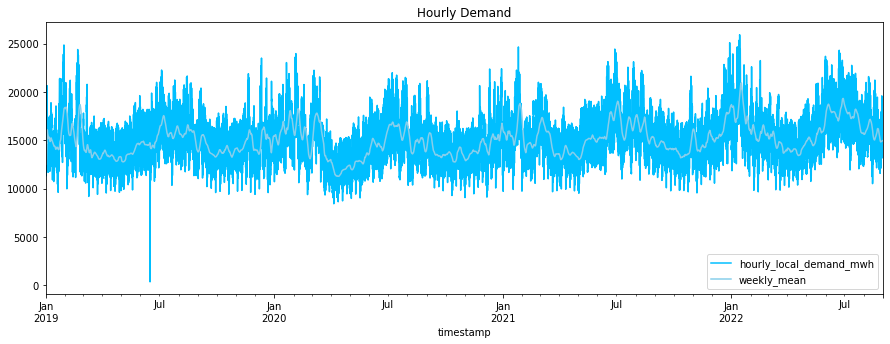

In [178]:
df_roll = df_hourly_demand.copy()
df_roll.set_index('timestamp', inplace=True)
df_roll['daily_mean'] = df_roll['hourly_local_demand_mwh'].rolling(min_periods=1, window='1D').mean()
df_roll['weekly_mean'] = df_roll['hourly_local_demand_mwh'].rolling(min_periods=1, window='7D').mean()
df_roll.reset_index(inplace=True)

plot_df(df_roll, time_since='2019-01-01', time_until='2022-09-01', time_col='timestamp'
    , left_feat_lst=['hourly_local_demand_mwh', 'weekly_mean']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Hourly Demand", xposition=[], yposition=[]
    , fig_size=[15, 5], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

nan

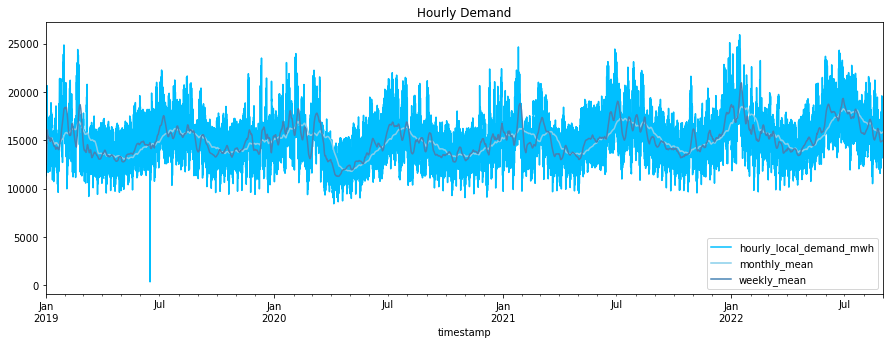

In [167]:
df_roll = df_hourly_demand.copy()
df_roll.set_index('timestamp', inplace=True)
df_roll['daily_mean'] = df_roll['hourly_local_demand_mwh'].rolling(min_periods=1, window='1D').mean()
df_roll['weekly_mean'] = df_roll['hourly_local_demand_mwh'].rolling(min_periods=1, window='7D').mean()
df_roll['monthly_mean'] = df_roll['hourly_local_demand_mwh'].rolling(min_periods=1, window='30D').mean()
df_roll.reset_index(inplace=True)

plot_df(df_roll, time_since='2019-01-01', time_until='2022-09-01', time_col='timestamp'
    , left_feat_lst=['hourly_local_demand_mwh', 'monthly_mean', 'weekly_mean']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Hourly Demand", xposition=[], yposition=[]
    , fig_size=[15, 5], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [179]:
df_hdemand = df_hourly_demand[['timestamp', 'hourly_local_demand_mwh']].copy()

In [180]:
sample = sorted([x for x in np.random.choice([x for x in df_hdemand.timestamp if x.hour == 0], 5, replace=False)])
df_hdemand

,timestamp,hourly_local_demand_mwh
0,2019-01-01 00:00:00,13497
1,2019-01-01 01:00:00,13363
2,2019-01-01 02:00:00,13298
3,2019-01-01 03:00:00,13129
4,2019-01-01 04:00:00,12869
...,...,...
32851,2022-09-30 19:00:00,15753
32852,2022-09-30 20:00:00,16516
32853,2022-09-30 21:00:00,16256
32854,2022-09-30 22:00:00,15476


### Daily Seasonal Efect

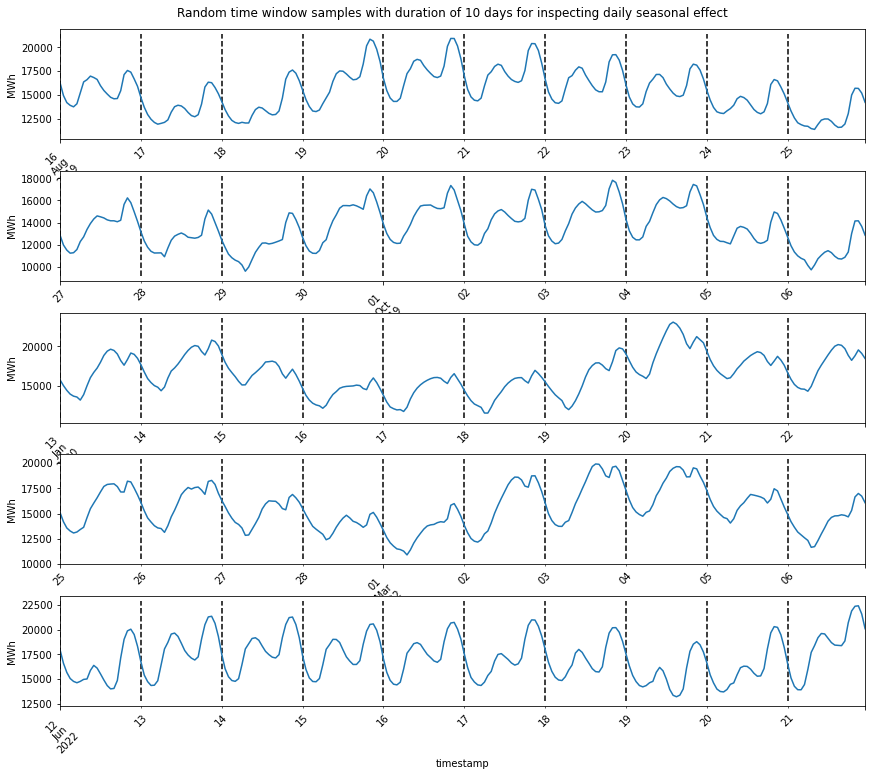

In [181]:
#drawing a random sample of 5 indices without repetition to analyze daily seasonability
sample = sorted([x for x in np.random.choice([x for x in df_hdemand.timestamp if x.hour == 0], 5, replace=False)])

#checking persistence of daily seasonality by inspecting 5 random time window of 10 days
f, axes = plt.subplots(len(sample), 1, figsize=(12, 10)); #dpi=100,
f.tight_layout() #pad=3.0)
plt.suptitle('Random time window samples with duration of 10 days for inspecting daily seasonal effect', y = 1.01, fontsize=12)

#plotting time windows and drawing vertical lines at begining of period
window = 24*10
for si, s in enumerate(sample):
    ids = df_hdemand[df_hdemand.timestamp==s].index.values[0]
    idx = [df_hdemand.iloc[x:x+1,:].timestamp.values[0] for x in range(ids, ids + window, 24)]
    df_hdemand.iloc[ids:(ids+window),:].plot('timestamp', 'hourly_local_demand_mwh', ax=axes[si], legend=False, rot=45, ylabel='MWh');
    axes[si].vlines(idx, axes[si].get_ylim()[0], axes[si].get_ylim()[1], colors='black', linestyles='dashed')

### Weekly Seasonal Efect?

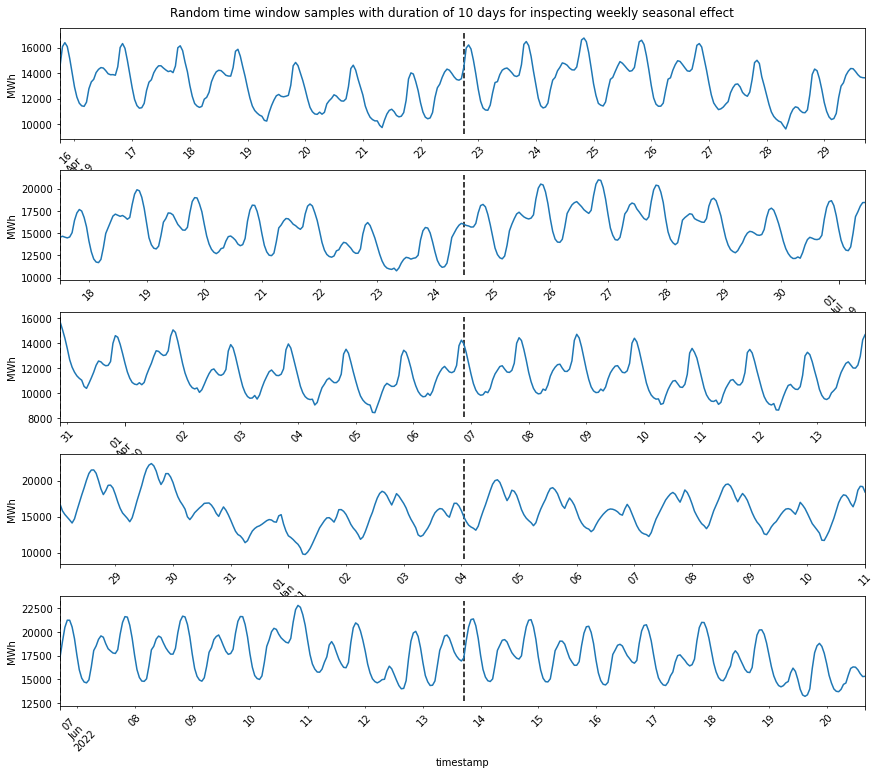

In [182]:
#drawing a random sample of 5 indices without repetition to analyze weekly seasonability
# Monday is 0 using weekday()
sample = sorted([x for x in np.random.choice([x for x in df_hdemand.timestamp if x.weekday() == 0], 5, replace=False)])

#checking persistence of daily seasonality by inspecting 5 random time window of 10 days
f, axes = plt.subplots(len(sample), 1, figsize=(12, 10)); #dpi=100,
f.tight_layout() #pad=3.0)
plt.suptitle('Random time window samples with duration of 10 days for inspecting weekly seasonal effect', y = 1.01, fontsize=12)

#plotting time windows and drawing vertical lines at begining of period
window = 24*14
for si, s in enumerate(sample):
    ids = df_hdemand[df_hdemand.timestamp==s].index.values[0]
    idx = [df_hdemand.iloc[x:x+1,:].timestamp.values[0] for x in range(ids, ids + window, 24*7)]
    df_hdemand.iloc[ids:(ids+window),:].plot('timestamp', 'hourly_local_demand_mwh', ax=axes[si], legend=False, rot=45, ylabel='MWh');
    axes[si].vlines(idx, axes[si].get_ylim()[0], axes[si].get_ylim()[1], colors='black', linestyles='dashed')

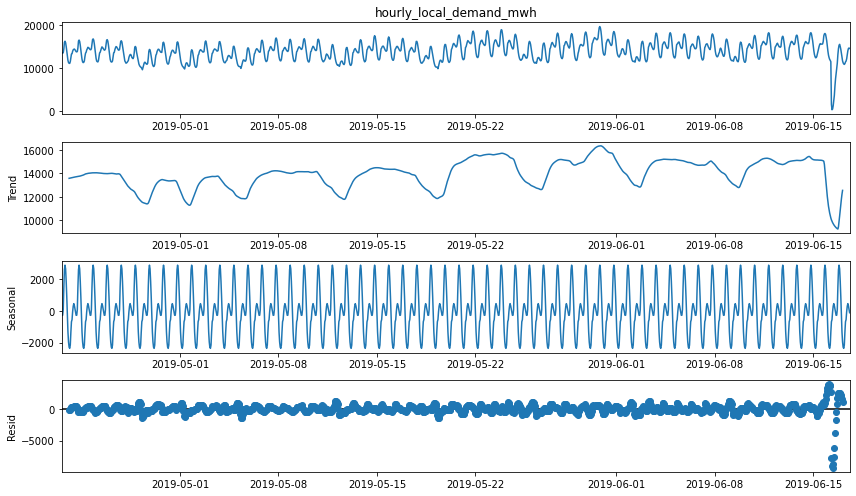

In [183]:
#drawing a random sample of 5 indices without repetition to analyze weekly seasonability
# Monday is 0 using weekday()
sample = sorted([x for x in np.random.choice([x for x in df_hdemand.timestamp if x.weekday() == 0], 5, replace=False)])

window=24*14*4
s=sample[0]
ids = df_hdemand[df_hdemand.timestamp==s].index.values[0]
idx = [x for x in range(ids, ids + window)]
df = df_hdemand.iloc[idx]
df.set_index('timestamp', inplace=True)
fig = sm.tsa.seasonal_decompose(df.hourly_local_demand_mwh, model='additive').plot()
fig.set_size_inches((12, 7))
# Tight layout to realign things
fig.tight_layout()
plt.show()

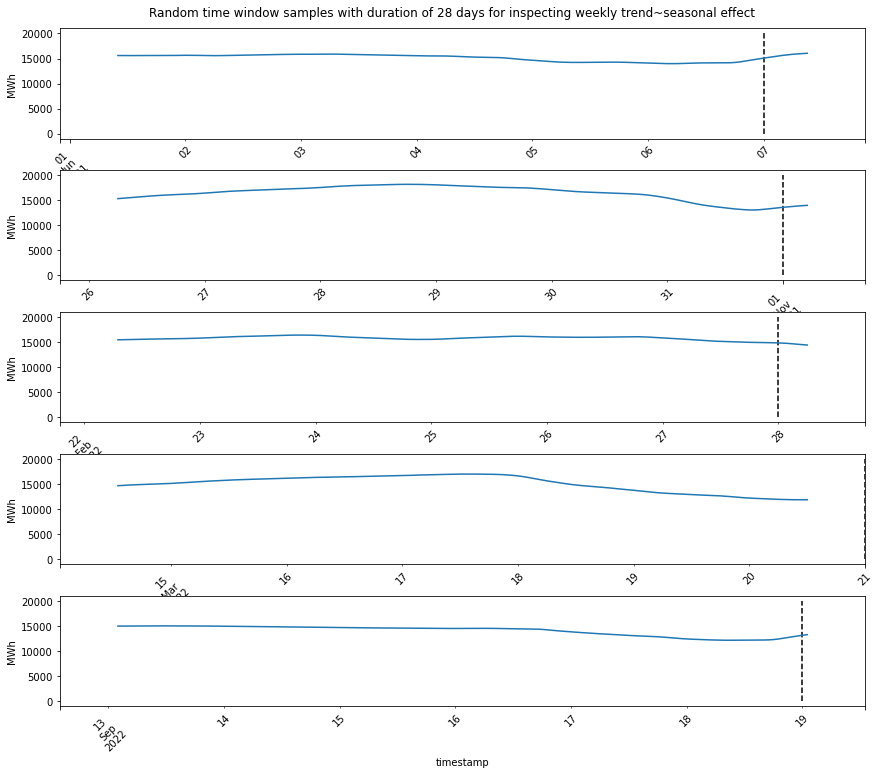

In [185]:
#drawing a random sample of 5 indices without repetition to analyze weekly seasonability
# Monday is 0 using weekday()
sample = sorted([x for x in np.random.choice([x for x in df_hdemand.timestamp if x.weekday() == 0], 5, replace=False)])

#checking persistence of daily seasonality by inspecting 5 random time window of 10 days
f, axes = plt.subplots(len(sample), 1, figsize=(12, 10)); #dpi=100,
f.tight_layout() #pad=3.0)
plt.suptitle('Random time window samples with duration of 28 days for inspecting weekly trend~seasonal effect', y = 1.01, fontsize=12)

#plotting time windows and drawing vertical lines at begining of period
window=24*7
for si, s in enumerate(sample):
    #s=sample[0]
    ids = df_hdemand[df_hdemand.timestamp==s].index.values[0]
    idx = [x for x in range(ids, ids + window)]
    df = df_hdemand.iloc[idx]
    df.set_index('timestamp', inplace=True)
    
    sd = sm.tsa.seasonal_decompose(df.hourly_local_demand_mwh, model='additive')
    df.reset_index(inplace=True)
    #ids = df[df.timestamp==s].index.values[0]
    v_lines = [df.loc[x].values[0] for x in df.index.values if (df.loc[x].timestamp.weekday()==0 and df.loc[x].timestamp.hour==0)]
    sd.trend.plot(ax=axes[si], legend=False, rot=45, ylabel='MWh')
    axes[si].vlines(v_lines, 0, 20000, colors='black', linestyles='dashed')

## Monthly Data

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 129


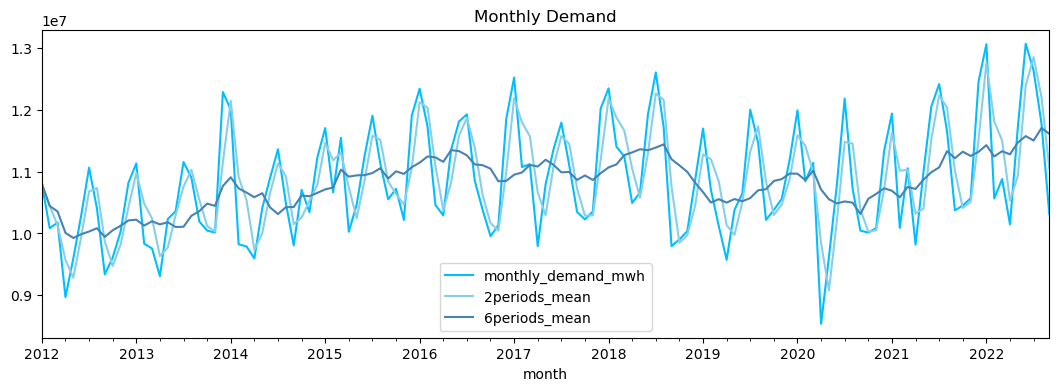

In [8]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """	select month
        	, sum(monthly_demand_mwh)	as monthly_demand_mwh
            from cammesa_db.monthly_demand
            group by month
            order by month
            """
process_ok, error_txt, df_monthly_demand = pg_select_to_pandas(cursor, sql_query, verbose=True)
df_monthly_demand.month = pd.to_datetime(df_monthly_demand.month)
cnxn.close()

df_mdemand = df_monthly_demand.copy()

df_roll = df_mdemand.copy()
if df_roll.index.name != 'month':
    df_roll.set_index('month', inplace=True)
df_roll['2periods_mean'] = df_roll['monthly_demand_mwh'].rolling(min_periods=1, window='60D').mean()
df_roll['6periods_mean'] = df_roll['monthly_demand_mwh'].rolling(min_periods=1, window='180D').mean()
df_roll.reset_index(inplace=True)

plot_df(df_roll, time_since='2012-01-01', time_until='2022-09-01', time_col='month'
    , left_feat_lst=['monthly_demand_mwh', '2periods_mean', '6periods_mean']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Monthly Demand", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

indexedDataset = df_mdemand.copy()
if indexedDataset.index.name != 'month':
    indexedDataset.set_index('month', inplace=True)

# Prophet Try 1

In [9]:
# https://pythonlang.dev/repo/facebook-prophet/
# prophet uses stan as base, so first you have to have pystan installed:
# pip install Cython
# pip install pystan==2.19.1.1
# pip install prophet

# SIN EMBARGO, finalmente funcionó con sólo:
# conda install -c conda-forge prophet

from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [10]:
if df_mdemand.index.name == 'month':
    df_mdemand.reset_index(inplace=True)

In [11]:
# Prophet also imposes the strict condition that the input columns must be named as ds (the time column) and y (the metric column).
df_mdemand_ph = df_mdemand.copy()
df_mdemand_ph.rename(columns={'month': 'ds', 'monthly_demand_mwh': 'y'}, inplace=True)

# set the uncertainty interval to 95% (the Prophet default is 80%)
# 4 minutes!!
model = Prophet(interval_width=0.95)#, stan_backend='CMDSTANPY')
# Fit to data
model.fit(df_mdemand_ph)

11:41:54 - cmdstanpy - INFO - Chain [1] start processing
11:41:54 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Forecast next 2 months:
# In Python, the frequency can be anything from the pandas list of frequency strings here: 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases .
future_dates = model.make_future_dataframe(periods=12, freq='MS')
future_dates.tail()

,ds
136,2023-05-01
137,2023-06-01
138,2023-07-01
139,2023-08-01
140,2023-09-01


In [13]:
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2012-01-01,10990530.8,10295217.1,11660666.2
1,2012-02-01,10111894.5,9366476.6,10849649.7
2,2012-03-01,9994251.2,9236337.1,10769723.5
3,2012-04-01,8803800.5,8104557.8,9551787.3
4,2012-05-01,9833512.0,9080768.6,10588177.3


nan

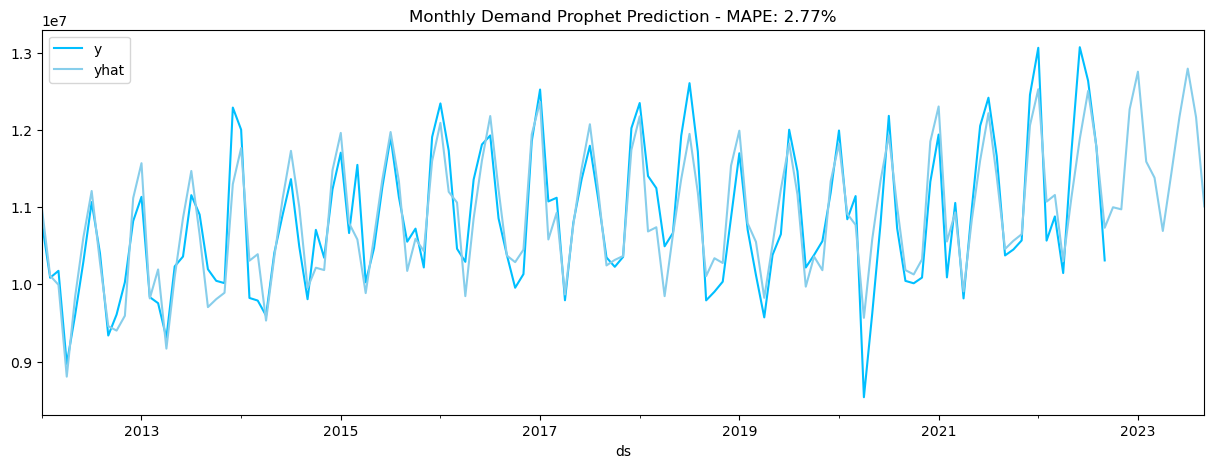

In [14]:
df_plot = df_mdemand_ph.merge(right=forecast[['ds', 'yhat']], on='ds', how='outer')
MAPE_prophet = mean_absolute_percentage_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values) * 100
plot_df(df_plot, time_since='2012-01-01', time_until=df_plot.ds.max(), time_col='ds'
    , left_feat_lst=['y', 'yhat']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Monthly Demand Prophet Prediction - MAPE: " + str(round(MAPE_prophet,2)) + '%', xposition=[], yposition=[]
    , fig_size=[15, 5], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None
        , ylim=[], texts=None)

### DANGER: The monthly difference between y and yhat shouldnt be more than 5%

In [15]:
# DANGER: The monthly difference between y and yhat shouldnt be more than 5%
(df_plot.y.fillna(0)[-24:-12] - df_plot.yhat.fillna(0)[-24:-12]) / df_plot.y.fillna(0)[-24:-12] * 100

117   -1.0
118   -0.7
119    3.3
120    4.2
121   -4.7
122   -2.5
123   -1.4
124    5.2
125    9.2
126    1.2
127    0.1
128   -4.0
dtype: float64

In [15]:
#calculating mean absolute error and root mean squared error for model evaluation
MAE_prophet = mean_absolute_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values)
RMSE_prophet = mean_squared_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values, squared=False)
MAPE_prophet = mean_absolute_percentage_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values) * 100

print(f'Mean absolute error (MAE): {"%.0f" % MAE_prophet}, Root mean squared error (RMSE): {"%.0f" % RMSE_prophet},',
    f' Mean absolute percentage error (MAPE): {"%.1f" % MAPE_prophet}% ')

Mean absolute error (MAE): 301114, Root mean squared error (RMSE): 376977,  Mean absolute percentage error (MAPE): 2.8% 


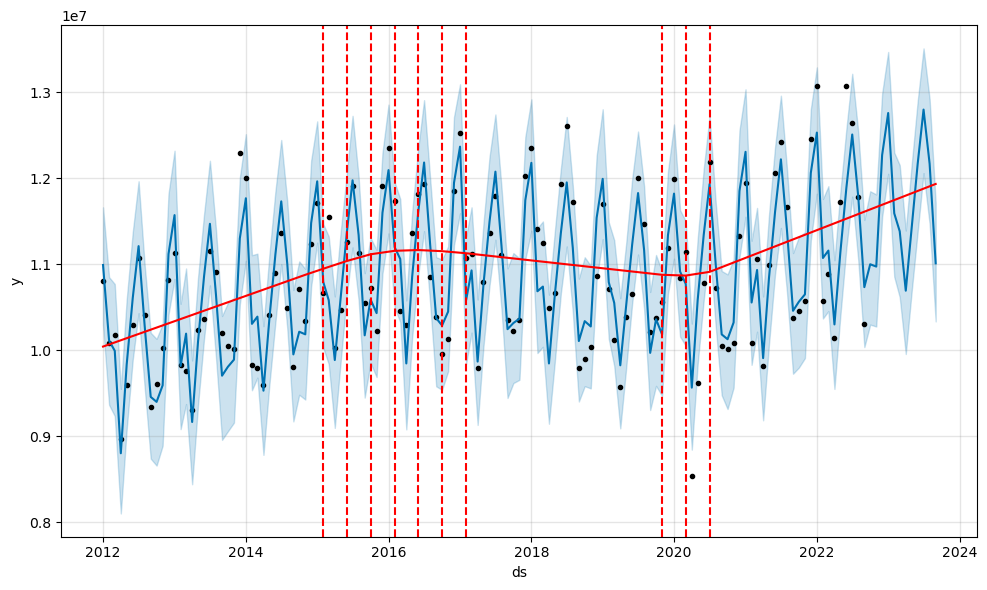

In [16]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [18]:
# To list changepoints:
#df_mdemand_ph.loc[df_mdemand_ph["ds"].isin(model.changepoints)]

<AxesSubplot:xlabel='month'>

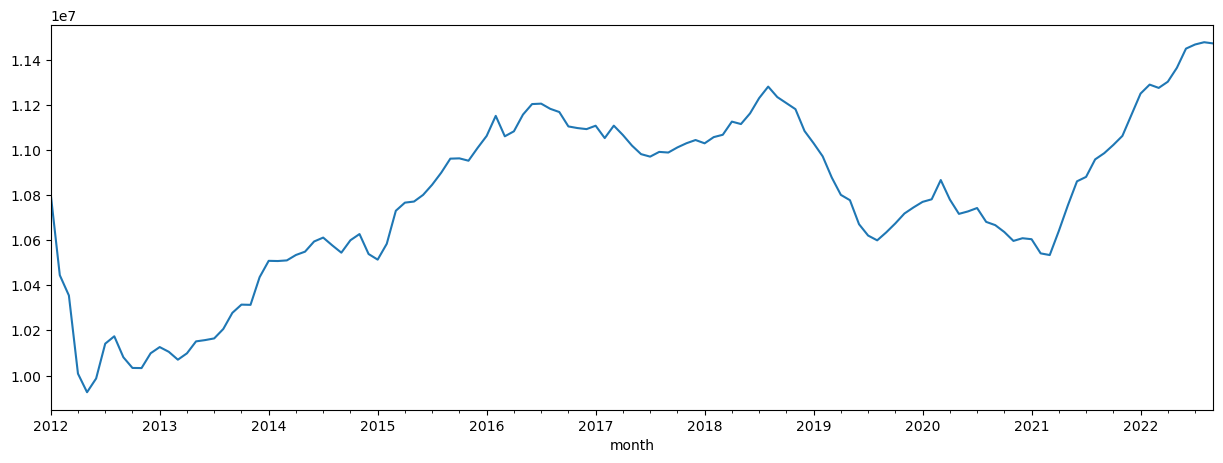

In [19]:
# Remember the trend:
df_mdemand.set_index('month').monthly_demand_mwh.rolling(window='365D').mean().plot(figsize=(15, 5))

In [17]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
# 4 minutes!!
model = Prophet(interval_width=0.95, changepoints=['2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01'
    , '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01'
    , '2019-05-01', '2019-06-01', '2019-07-01', '2021-02-01', '2021-03-01', '2021-04-01'])
# Fit to data
model.fit(df_mdemand_ph)

11:42:27 - cmdstanpy - INFO - Chain [1] start processing
11:42:27 - cmdstanpy - INFO - Chain [1] done processing


nan

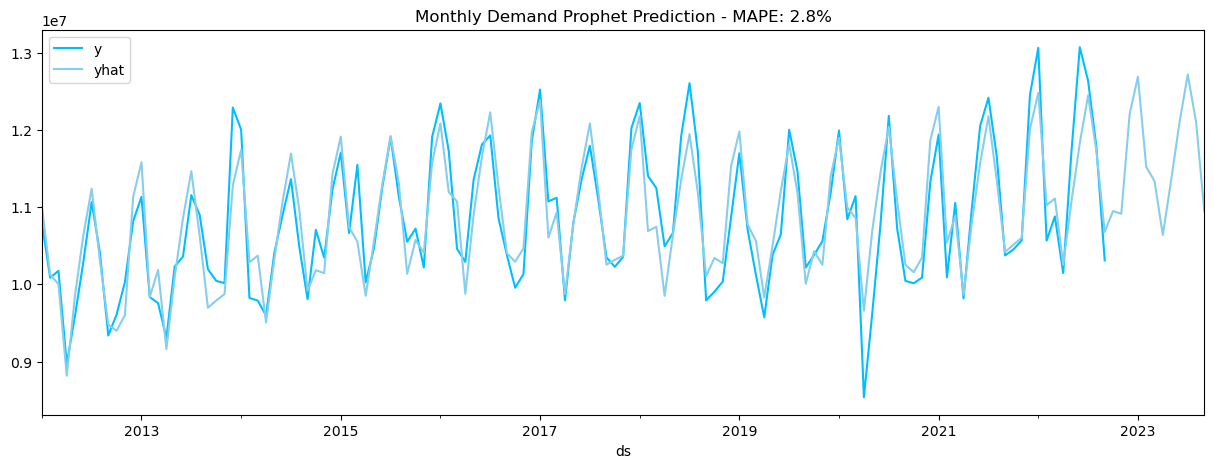

In [18]:
# Forecast next 2 months:
future_dates = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()
df_plot = df_mdemand_ph.merge(right=forecast[['ds', 'yhat']], on='ds', how='outer')
MAPE_prophet = mean_absolute_percentage_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values) * 100
plot_df(df_plot, time_since='2012-01-01', time_until=df_plot.ds.max(), time_col='ds'
    , left_feat_lst=['y', 'yhat']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Monthly Demand Prophet Prediction - MAPE: " + str(round(MAPE_prophet,2)) + '%', xposition=[], yposition=[]
    , fig_size=[15, 5], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None
        , ylim=[], texts=None)

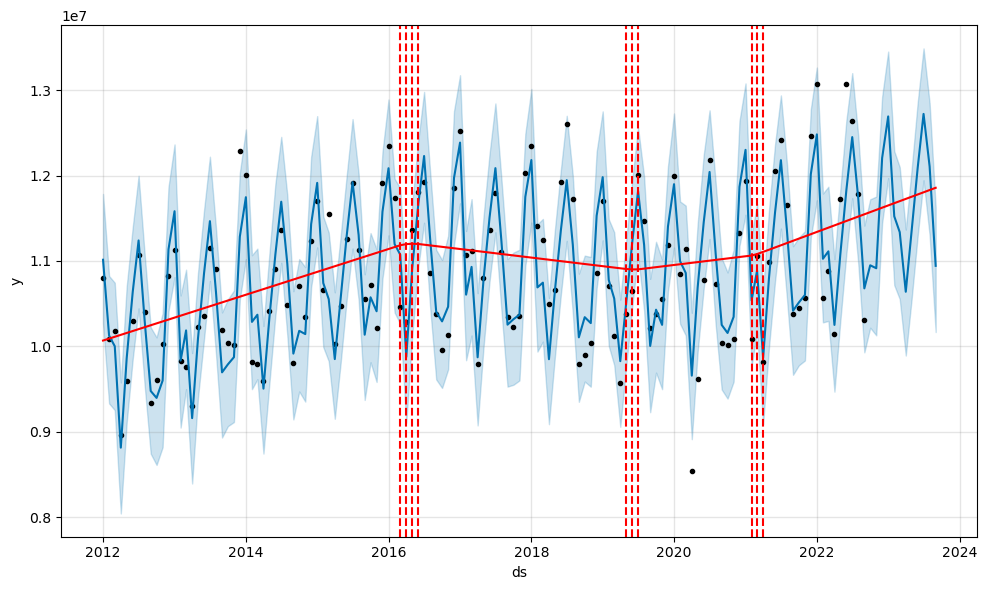

In [19]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

# PENDING: prophet on hourly data

In [186]:
# conda install -c conda-forge fbprophet
from prophet import Prophet
#from fbprophet.plot import plot_plotly
#import plotly.offline as py

In [187]:
# The Prophet library expects as input a dataframe with one column containing the time information (must be of the datetime type)
# and another column containing the metric that we wish to forecast.
df_hdemand = df_hourly_demand[['timestamp', 'hourly_local_demand_mwh']].copy()
df_hdemand.dtypes

timestamp                  datetime64[ns]
hourly_local_demand_mwh             int64
dtype: object

In [188]:
# Prophet also imposes the strict condition that the input columns must be named as ds (the time column) and y (the metric column).
df_hdemand.rename(columns={'timestamp': 'ds', 'hourly_local_demand_mwh': 'y'}, inplace=True)
df_hdemand.head(2)

,ds,y
0,2019-01-01 00:00:00,13497
1,2019-01-01 01:00:00,13363


In [189]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
# 4 minutes!!
model = Prophet(interval_width=0.95)
# Fit to data
model.fit(df_hdemand)

In [190]:
# Forecast next 7 days:
future_dates = model.make_future_dataframe(periods=24*7, freq='H')
future_dates.tail()

,ds
33019,2022-10-07 19:00:00
33020,2022-10-07 20:00:00
33021,2022-10-07 21:00:00
33022,2022-10-07 22:00:00
33023,2022-10-07 23:00:00


In [191]:
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-01 00:00:00,14999.3,12262.4,17984.7
1,2019-01-01 01:00:00,14074.1,11154.5,17218.1
2,2019-01-01 02:00:00,13453.4,10779.1,16241.4
3,2019-01-01 03:00:00,13086.8,10057.3,15834.4
4,2019-01-01 04:00:00,12902.7,10162.0,15674.2


<Figure size 1296x360 with 0 Axes>

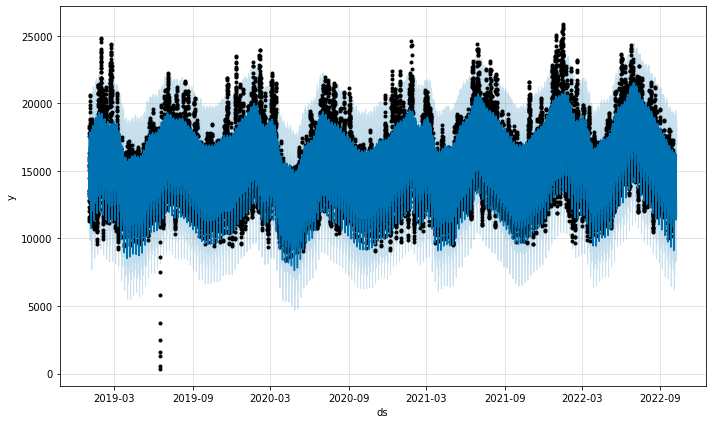

In [38]:
# Plot the results
plt.figure(figsize=[18, 5])
fig1 = model.plot(forecast, uncertainty=True)

In [40]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'], dtype='object')

nan

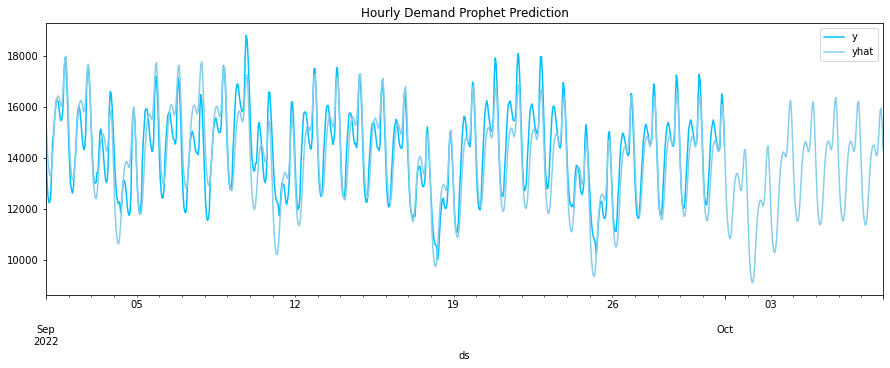

In [192]:
df_plot = df_hdemand.merge(right=forecast[['ds', 'yhat']], on='ds', how='outer')
plot_df(df_plot, time_since='2022-09-01', time_until=df_plot.ds.max(), time_col='ds'
    , left_feat_lst=['y', 'yhat']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Hourly Demand Prophet Prediction", xposition=[], yposition=[]
    , fig_size=[15, 5], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [193]:
#calculating mean absolute error and root mean squared error for model evaluation
MAE_prophet = mean_absolute_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values)
RMSE_prophet = mean_squared_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values, squared=False)
MAPE_prophet = mean_absolute_percentage_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values) * 100

print(f'Mean absolute error (MAE): {"%.0f" % MAE_prophet}, Root mean squared error (RMSE): {"%.0f" % RMSE_prophet},',
    f' Mean absolute percentage error (MAPE): {"%.1f" % MAPE_prophet}% ')

Mean absolute error (MAE): 1105, Root mean squared error (RMSE): 1468,  Mean absolute percentage error (MAPE): 7.6% 


In [42]:
MAE_prophet / df_hdemand.y.mean()

0.07347140927900485

# Prophet Optimization

## Forecasting Growth?
https://facebook.github.io/prophet/docs/saturating_forecasts.html

In [ ]:
df_roll = df_hourly_demand.copy()
df_roll.set_index('timestamp', inplace=True)
df_roll['daily_mean'] = df_roll['hourly_local_demand_mwh'].rolling(min_periods=1, window='1D').mean()
df_roll['weekly_mean'] = df_roll['hourly_local_demand_mwh'].rolling(min_periods=1, window='7D').mean()
df_roll['monthly_mean'] = df_roll['hourly_local_demand_mwh'].rolling(min_periods=1, window='30D').mean()
df_roll.reset_index(inplace=True)

plot_df(df_roll, time_since='2019-01-01', time_until='2022-09-01', time_col='timestamp'
    , left_feat_lst=['hourly_local_demand_mwh', 'monthly_mean', 'weekly_mean']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Hourly Demand", xposition=[], yposition=[]
    , fig_size=[15, 5], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [168]:
import statsmodels.api as sm

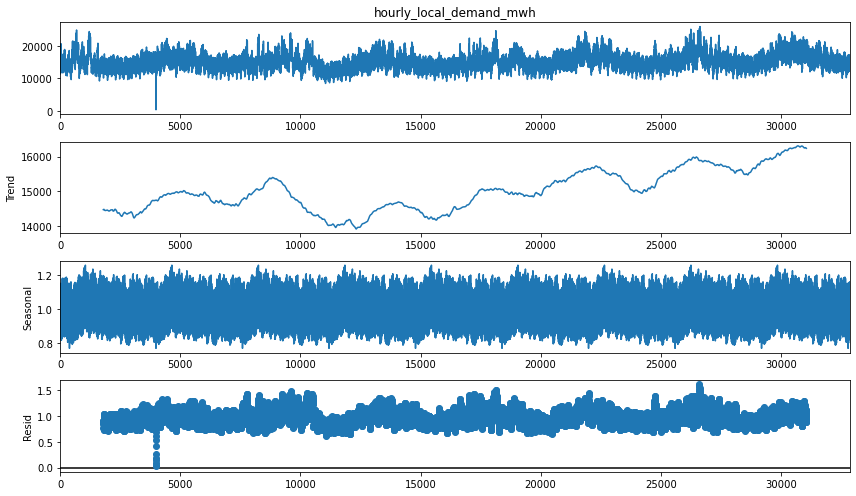

In [176]:
# period: period of signal in seconds
fig = sm.tsa.seasonal_decompose(df_hdemand.hourly_local_demand_mwh, model='multiplicative', period=int(60*60)).plot()
fig.set_size_inches((12, 7))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [ ]:
# https://xang1234.github.io/prophet/